# Group Coordinates

In [11]:
import pandas as pd
import cv2 
import numpy as np 
import matplotlib.pyplot as plt

In [23]:
df_original = pd.read_csv("/Users/christianheeb/Desktop/tennis_tracking_mapping/object_positions.csv")

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Frame   992 non-null    int64
 1   ID      992 non-null    int64
 2   X       992 non-null    int64
 3   Y       992 non-null    int64
 4   W       992 non-null    int64
 5   H       992 non-null    int64
dtypes: int64(6)
memory usage: 46.6 KB


In [28]:
# check for double entries and drop the frames with smaller W*H area
df_original["Area"] = df_original["W"] * df_original["H"]

# Sort the DataFrame based on Frame and Area in descending order
df_sorted = df_original.sort_values(by=["Frame", "Area"], ascending=[True, False])

# Drop duplicates keeping the entry with the largest area for each Frame
df_deduplicated = df_sorted.drop_duplicates(subset="Frame", keep="first").sort_index()

# Drop the Area column 
df_final = df_deduplicated.drop(columns="Area")

print(df_final)


     Frame  ID    X    Y   W    H
0        5   0  444   93  49   95
1        6   0  473  102  26   88
2        8   1  486  111  27   88
3        9   1  491  118  29   88
4       10   1  497  124  29   92
..     ...  ..  ...  ...  ..  ...
987   1026  86  527  107  68  112
988   1027  86  526   95  67  124
989   1028  86  523   95  68  125
990   1029  86  514   93  76  127
991   1030  86  503  106  87  114

[940 rows x 6 columns]


# Transform Coordinates to 2D Space

In [62]:
df = df_final

# provide points from image 1 with GIMP
pts_src = np.array([[126, 593], [1157, 593], [890, 147], [404, 147], [644, 290]])

# corresponding points from image 2
pts_dst = np.array([[112, 547],[279, 548],[277, 189], [113, 189], [194, 370]])

# calculate matrix H
h, status = cv2.findHomography(pts_src, pts_dst)

def transform_coordinates(row):
    # Create an array from the X and Y coordinates
    a = np.array([[row["X"], row["Y"]]], dtype="float32")
    a = np.array([a])
    # Perform the perspective transformation
    points_out = cv2.perspectiveTransform(a, h)
    # Extract the new coordinates and return them
    x_new, y_new = points_out[0][0]
    return pd.Series({"X_new": x_new, "Y_new": y_new})

# Apply the transformation to each row
transformed_coords = df.apply(transform_coordinates, axis=1)

df = pd.concat([df, transformed_coords], axis=1)

# remove lines with negative values
df = df[(df["X_new"] >= 0) & (df["Y_new"] >= 0)]

df.head(40)

,Frame,ID,X,Y,W,H,X_new,Y_new
0,5,0,444,93,49,95,114.460258,83.113350
1,6,0,473,102,26,88,127.665070,103.050682
2,8,1,486,111,27,88,134.246506,122.021713
3,9,1,491,118,29,88,137.272461,136.144699
4,10,1,497,124,29,92,140.394516,147.830811
5,11,1,497,134,28,63,141.870911,166.506622
6,12,2,467,199,69,37,140.855759,267.683624
7,23,3,409,183,44,57,120.719788,245.583969
9,24,5,353,137,91,104,92.179573,171.986725
10,25,5,362,134,70,106,94.515884,166.573471


In [59]:
# Save
df.to_csv("/Users/christianheeb/Desktop/tennis_tracking_mapping/transformed_coordinates.csv", index=False)
df.head(20)

,Frame,ID,X,Y,W,H,X_new,Y_new
0,5,0,444,93,49,95,114.460258,83.113350
1,6,0,473,102,26,88,127.665070,103.050682
2,8,1,486,111,27,88,134.246506,122.021713
3,9,1,491,118,29,88,137.272461,136.144699
4,10,1,497,124,29,92,140.394516,147.830811
5,11,1,497,134,28,63,141.870911,166.506622
6,12,2,467,199,69,37,140.855759,267.683624
7,23,3,409,183,44,57,120.719788,245.583969
9,24,5,353,137,91,104,92.179573,171.986725
10,25,5,362,134,70,106,94.515884,166.573471


# Plot coordinates on Picture

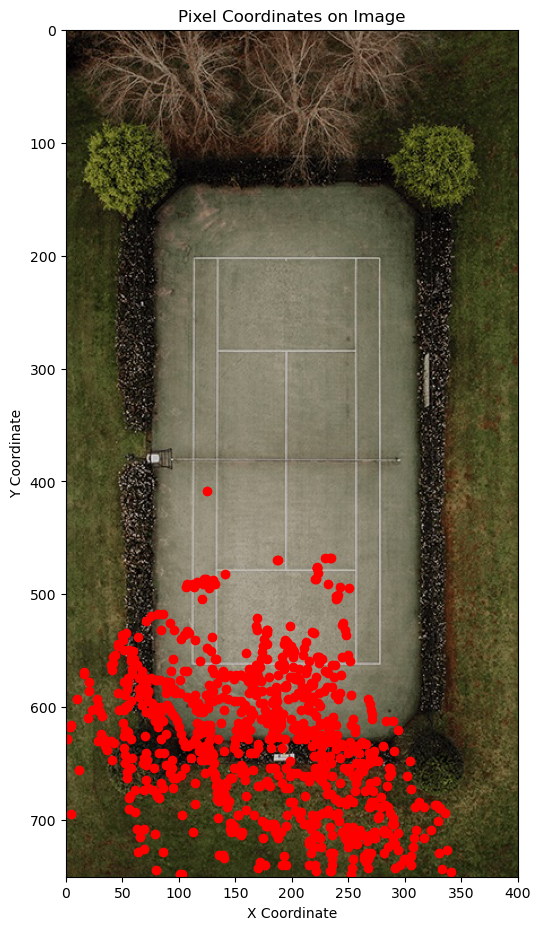

In [61]:
df = pd.read_csv("/Users/christianheeb/Desktop/tennis_tracking_mapping/transformed_coordinates.csv")

# Load image
img = plt.imread("/Users/christianheeb/Desktop/tennis_tracking_mapping/99_pictures_videos/tennis_court.jpg")

# Create a new figure
plt.figure(figsize=(20,11))

# Show the image
plt.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])

# Scatter plot of coordinates
plt.scatter(df["X_new"], img.shape[0] - df["Y_new"], color="red") 

# Set the y-axis to have the origin on the top
plt.ylim(plt.ylim()[::-1])

# labels and title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Pixel Coordinates on Image")

plt.show()